In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import shapely
import geopandas as gpd
import salem

import dask
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [4]:
# Sea-ice freshwater flux (m^3/s)
oceFW_si = (ecco.SIempmr.where(ecco.hFacC[0].values==1)+ecco.SIatmFW.where(ecco.hFacC[0].values==1))/rhoconst*ecco.rA

# Evaporation  (m^3/s)
oceFW_evap = ecco.EXFevap.where(ecco.hFacC[0].values==1)*ecco.rA

# Precipitation  (m^3/s)
oceFW_preci = ecco.EXFpreci.where(ecco.hFacC[0].values==1)*ecco.rA

# Evaporation minus Precipitation (m^3/s)
#oceFW_emp = (ecco.EXFevap.where(ecco.hFacC[0].values==1)-ecco.EXFpreci.where(ecco.hFacC[0].values==1))*ecco.rA
oceFW_emp = (ecco.SIatmFW-(ecco.EXFroff*rhoconst))/rhoconst*ecco.rA
# SIatmFW including sea ice

# Runoff (m^3/s)
oceFW_roff = ecco.EXFroff.where(ecco.hFacC[0].values==1)*ecco.rA

In [5]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [6]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [7]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [8]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:

In [9]:
# Create mask for SPNA
df = ecco.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('face','j','i')
ecco['mask_spna'] = mask_spna.where(ecco.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('face','j','i')
ecco['mask_nsea'] = mask_nsea.where(ecco.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('face','j','i')
ecco['mask_lsea'] = mask_lsea.where(ecco.hFacC[0].values==1,0)

In [10]:
terms = ['forcFwSI', 'forcFwE', 'forcFwP', 'forcFwEP', 'forcFwRO']

budg_fw = []

for mask in [ecco.mask_spna,ecco.mask_nsea,ecco.mask_lsea]:
    
    # Sea ice forcing (m^3/s)
    forcFwSI_mask = (oceFW_si*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    # Evaporation (m^3/s)
    forcFwE_mask = (oceFW_evap*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    # Precipitation (m^3/s)
    forcFwP_mask = (oceFW_preci*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    # Atmospheric freshwater forcing (m^3/s)
    forcFwEP_mask = (oceFW_emp*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    # Runoff forcing (m^3/s)
    forcFwRO_mask = (oceFW_roff*mask.where(mask==1)).sum(dim=['face','j','i'])
    
    results = dask.compute(-forcFwSI_mask.reset_coords(drop=True)*Sv, 
                           -forcFwE_mask.reset_coords(drop=True)*Sv, 
                           forcFwP_mask.reset_coords(drop=True)*Sv,
                           forcFwEP_mask.reset_coords(drop=True)*Sv, 
                           forcFwRO_mask.reset_coords(drop=True)*Sv)
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_fw.append(budg)

In [11]:
region = ['spna', 'nsea', 'lsea']
budg_fw = xr.concat(budg_fw,pd.Index(region, name='region'))

In [12]:
ds = budg_fw.to_dataset(name='fw')

In [13]:
ds

<xarray.Dataset>
Dimensions:  (region: 3, term: 5, time: 288)
Coordinates:
  * term     (term) object 'forcFwSI' 'forcFwE' 'forcFwP' 'forcFwEP' 'forcFwRO'
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14T12:00:00
  * region   (region) object 'spna' 'nsea' 'lsea'
Data variables:
    fw       (region, term, time) float64 -0.004108 0.03553 ... 0.001666

<xarray.Dataset>
Dimensions:  (region: 3, term: 3, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14T12:00:00
  * term     (term) object 'forcFwSI' 'forcFwEP' 'forcFwRO'
  * region   (region) object 'spna' 'nsea' 'lsea'
Data variables:
    fw       (region, term, time) float64 -0.004108 0.03553 ... 0.001666

In [16]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_fw_oceFW.nc', format='NETCDF4', 
             encoding={'fw': {'zlib': True}})

In [17]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budg_fw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw_oceFW.nc').fw

### Plot

In [11]:
import datetime

#### Fluxes

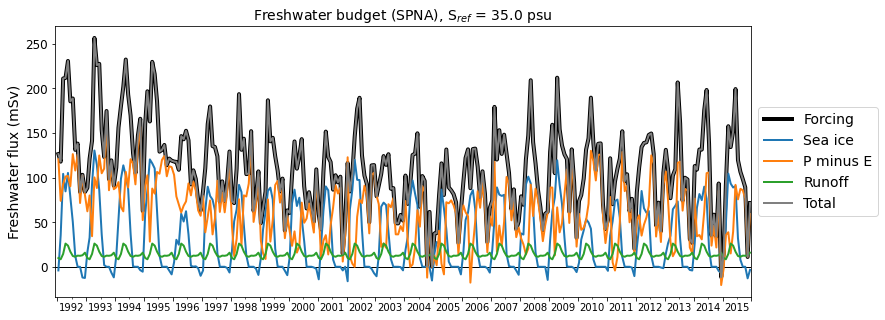

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw.time, budgFw.sel(region='spna',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwSI')*1e3, lw=2,label='Sea ice')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwEP')*1e3, lw=2,label='P minus E')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwRO')*1e3, lw=2,label='Runoff')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e3, 
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

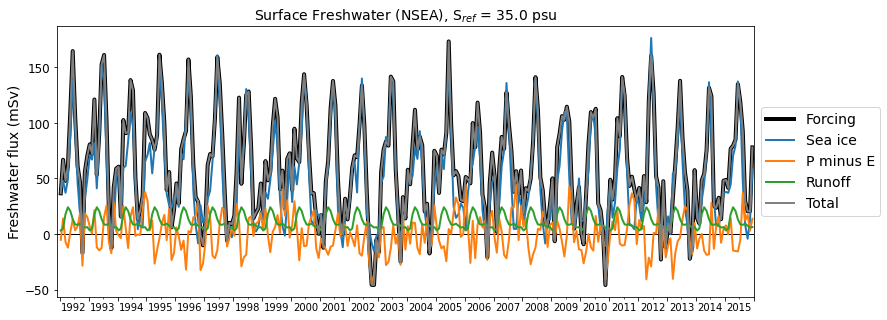

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Surface Freshwater (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw.time, budgFw.sel(region='nsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwSI')*1e3, lw=2,label='Sea ice')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwEP')*1e3, lw=2,label='P minus E')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e3, 
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

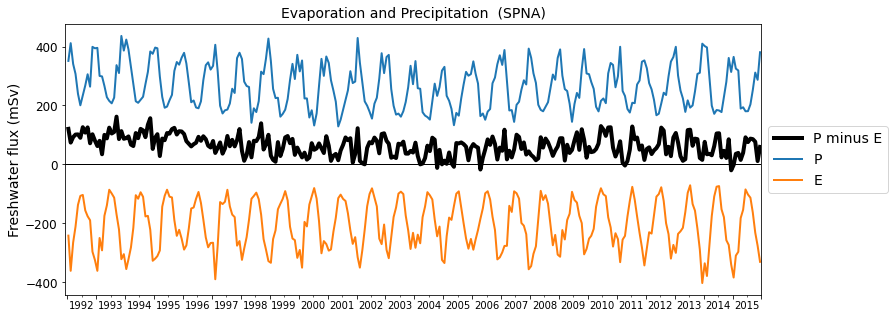

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwEP')*1e3, lw=4, color='black', label='P minus E')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwP')*1e3, lw=2, label='P')
ax.plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwE')*1e3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

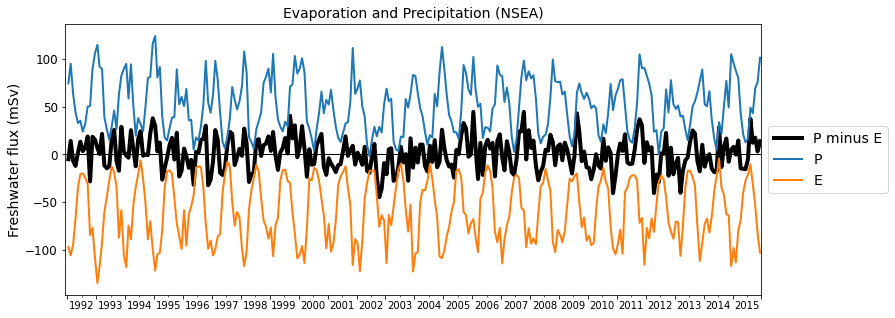

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwEP')*1e3, lw=4, color='black', label='P minus E')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwP')*1e3, lw=2, label='P')
ax.plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwE')*1e3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])

ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

#### Flux anomalies

In [19]:
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
budgfw_anom = budg_fw.groupby('time.month') - budg_fw.groupby('time.month').mean('time')

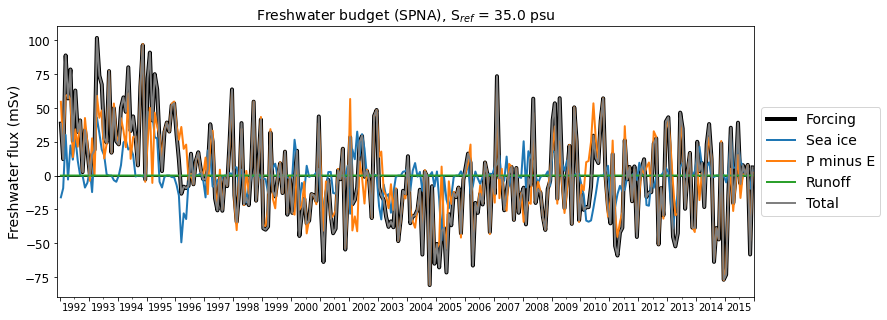

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwSI')*1e3, lw=2,label='Sea ice')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwEP')*1e3, lw=2,label='P minus E')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwRO')*1e3, lw=2,label='Runoff')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e3,
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

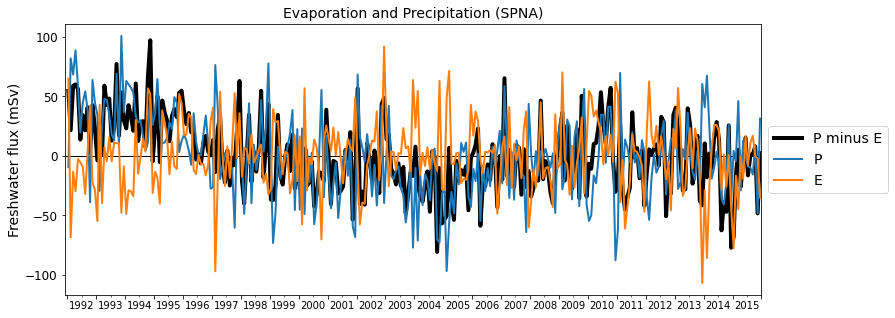

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwEP')*1e3, lw=4, color='black', label='P minus E')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwP')*1e3, lw=2, label='P')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwE')*1e3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

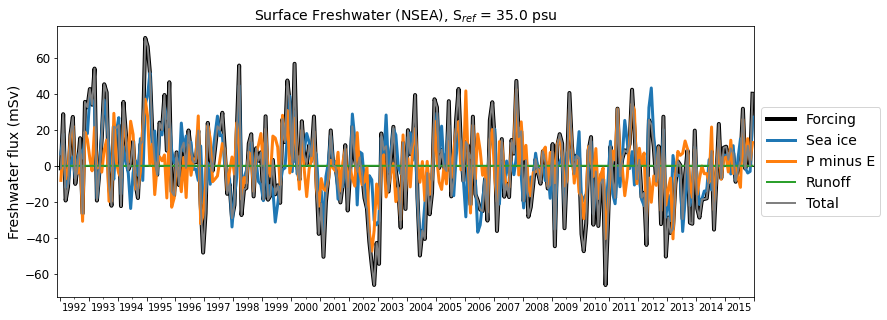

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Surface Freshwater (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwSI')*1e3, lw=3,label='Sea ice')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwEP')*1e3, lw=3,label='P minus E')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e3, 
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

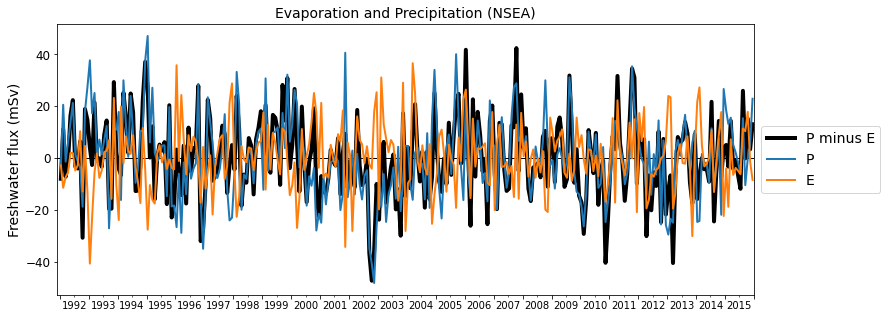

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwEP')*1e3, lw=4, color='black', label='P minus E')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwP')*1e3, lw=2, label='P')
ax.plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwE')*1e3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

#### Integrated anomalies

In [20]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgfw_int = (budgfw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

budgFw_int = budgFw_int.sel(time=slice('1993-01-01','2015-12-31'))
budgfw_int = budgfw_int.sel(time=slice('1993-01-01','2015-12-31'))

budgFw_int_anom = budgFw_int - budgFw_int.mean('time')
budgfw_int_anom = budgfw_int - budgfw_int.mean('time')

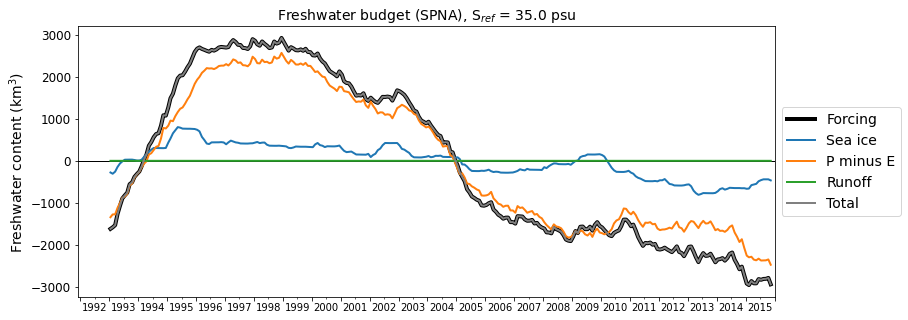

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (SPNA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_int_anom.time,budgFw_int_anom.sel(region='spna',term='forcFw')*1e-3,lw=4,color='black',label='Forcing')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='spna',term='forcFwSI')*1e-3, lw=2,label='Sea ice')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='spna',term='forcFwEP')*1e-3, lw=2,label='P minus E')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='spna',term='forcFwRO')*1e-3, lw=2,label='Runoff')
ax.plot(budgfw_int_anom.time,
        budgfw_int_anom.sel(region='spna',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e-3, 
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater content (km$^3$)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

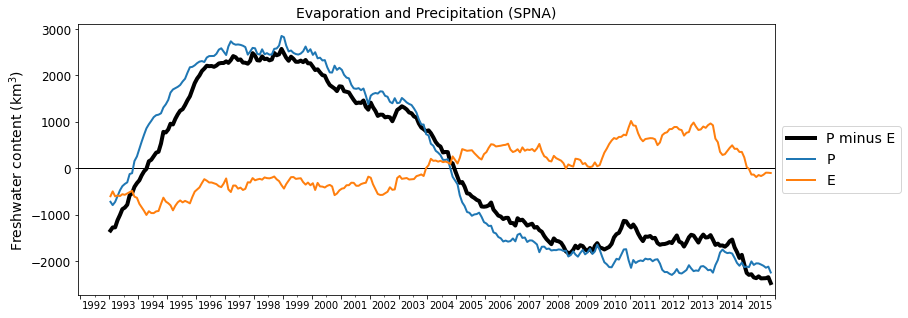

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwEP')*1e-3, lw=4, color='black', 
        label='P minus E')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwP')*1e-3, lw=2, label='P')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwE')*1e-3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater content (km$^3$)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

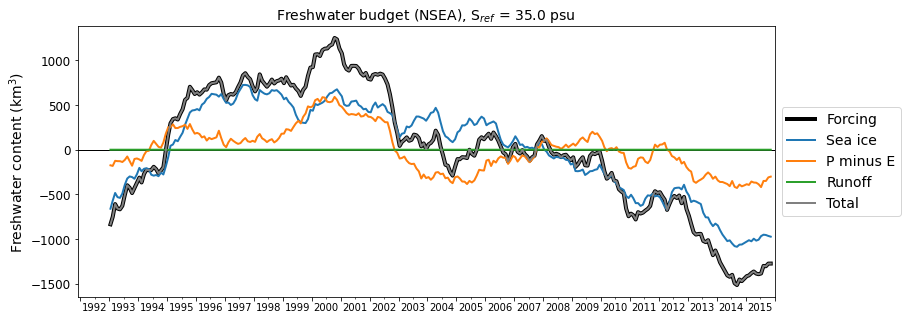

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Freshwater budget (NSEA), S$_{ref}$ = 35.0 psu',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_int_anom.time,budgFw_int_anom.sel(region='nsea',term='forcFw')*1e-3,lw=4,color='black',label='Forcing')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwSI')*1e-3, lw=2,label='Sea ice')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwEP')*1e-3, lw=2,label='P minus E')
ax.plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwRO')*1e-3, lw=2,label='Runoff')
ax.plot(budgfw_int_anom.time,
        budgfw_int_anom.sel(region='nsea',term=['forcFwSI','forcFwEP','forcFwRO']).sum('term')*1e-3, 
        color='grey', lw=2,label='Total')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater content (km$^3$)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

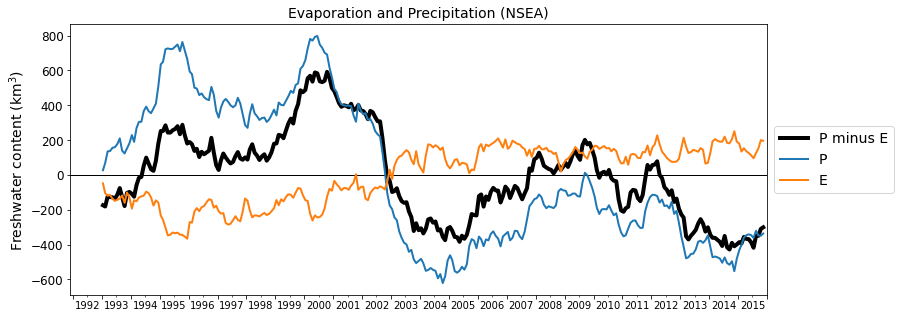

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Evaporation and Precipitation (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwEP')*1e-3, lw=4, color='black', 
        label='P minus E')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwP')*1e-3, lw=2, label='P')
ax.plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwE')*1e-3, lw=2, label='E')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Freshwater content (km$^3$)',fontsize=14)
#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

In [21]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


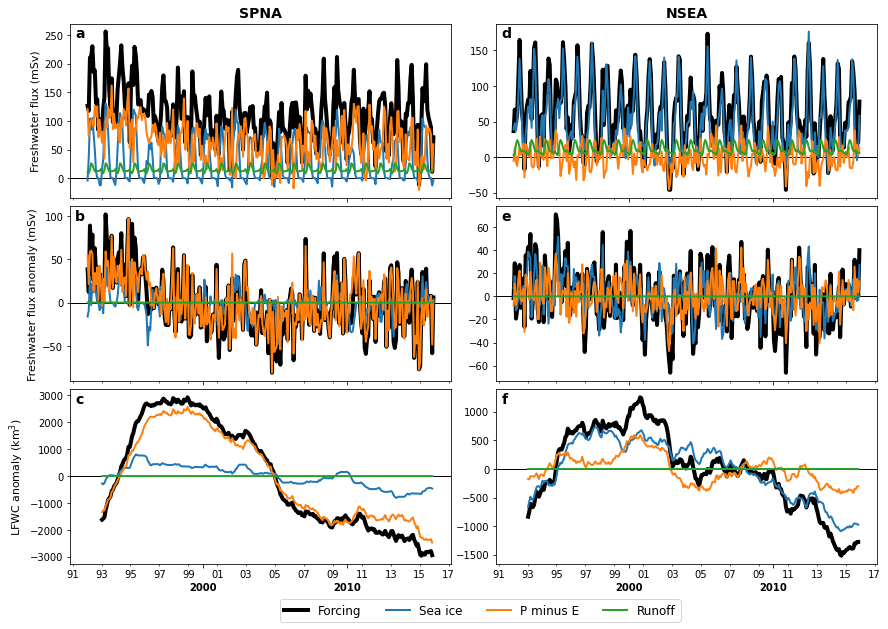

In [22]:
fig, axs = plt.subplots(3, 2,sharex=True, figsize=(14, 10))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw.time, budgFw.sel(region='spna',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[0,0].plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwSI')*1e3, lw=2,label='Sea ice')
axs[0,0].plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwEP')*1e3, lw=2,label='P minus E')
axs[0,0].plot(budg_fw.time, budg_fw.sel(region='spna',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[0,0].plot(budg_fw.time, budg_fw.sel(region='spna').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[0,0].set_ylabel('Freshwater flux (mSv)',fontsize=11)
axs[0,0].text(0.013,0.92, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'SPNA', fontsize=14, fontweight='bold')

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[1,0].plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwSI')*1e3, lw=2,label='Sea ice')
axs[1,0].plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwEP')*1e3, lw=2,label='P minus E')
axs[1,0].plot(budgfw_anom.time, budgfw_anom.sel(region='spna',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[1,0].plot(budgfw_anom.time, budgfw_anom.sel(region='spna').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[1,0].set_ylabel(r'Freshwater flux anomaly (mSv)', fontsize=11)
axs[1,0].text(0.013,0.92, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)

axs[2,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[2,0].plot(budgFw_int_anom.time, budgFw_int_anom.sel(region='spna',term='forcFw')*1e-3,
              lw=4, color='black', label='Forcing')
axs[2,0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwSI')*1e-3,
              lw=2, label='Sea ice')
axs[2,0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwEP')*1e-3,
              lw=2, label='P minus E')
axs[2,0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwRO')*1e-3,
              lw=2, label='Runoff')
axs[2,0].set_ylabel('LFWC anomaly (km$^3$)',fontsize=11)
axs[2,0].text(0.013,0.92, 'c', fontsize=14, fontweight='bold', transform=axs[2,0].transAxes)
format_xaxis(axs[2,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw.time, budgFw.sel(region='nsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[0,1].plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwSI')*1e3, lw=2,label='Sea ice')
axs[0,1].plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwEP')*1e3, lw=2,label='P minus E')
axs[0,1].plot(budg_fw.time, budg_fw.sel(region='nsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[0,1].plot(budg_fw.time, budg_fw.sel(region='nsea').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[0,1].text(0.013,0.92, 'd', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'NSEA', fontsize=14, fontweight='bold')

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[1,1].plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwSI')*1e3, lw=2,label='Sea ice')
axs[1,1].plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwEP')*1e3, lw=2,label='P minus E')
axs[1,1].plot(budgfw_anom.time, budgfw_anom.sel(region='nsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[1,1].plot(budgfw_anom.time, budgfw_anom.sel(region='nsea').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[1,1].text(0.013,0.92, 'e', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)

axs[2,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[2,1].plot(budgFw_int_anom.time, budgFw_int_anom.sel(region='nsea',term='forcFw')*1e-3,
              lw=4, color='black', label='Forcing')
axs[2,1].plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwSI')*1e-3, lw=2,label='Sea ice')
axs[2,1].plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwEP')*1e-3, lw=2,label='P minus E')
axs[2,1].plot(budgfw_int_anom.time,budgfw_int_anom.sel(region='nsea',term='forcFwRO')*1e-3, lw=2,label='Runoff')
axs[2,1].text(0.013,0.92, 'f', fontsize=14, fontweight='bold', transform=axs[2,1].transAxes)
format_xaxis(axs[2,1])

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)
axs[2,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.5, -0.17), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


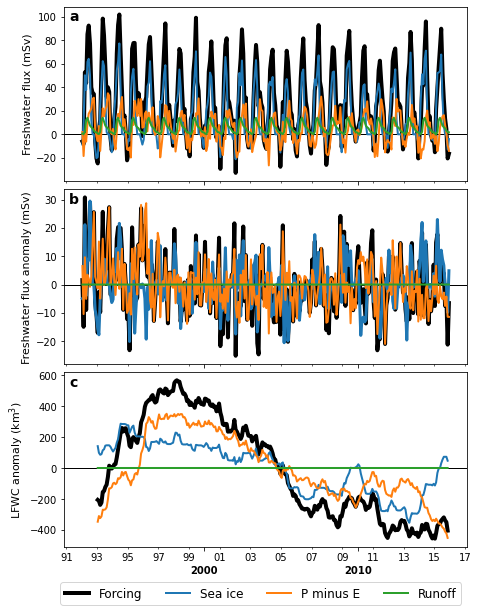

In [23]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 10))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgFw.time, budgFw.sel(region='lsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[0].plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFwSI')*1e3, lw=2,label='Sea ice')
axs[0].plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFwEP')*1e3, lw=2,label='P minus E')
axs[0].plot(budg_fw.time, budg_fw.sel(region='lsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[0].plot(budg_fw.time, budg_fw.sel(region='lsea').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[0].set_ylabel('Freshwater flux (mSv)',fontsize=11)
axs[0].text(0.013,0.92, 'a', fontsize=14, fontweight='bold', transform=axs[0].transAxes)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='forcFw')*1e3, lw=4, color='black',label='Forcing')
axs[1].plot(budgfw_anom.time, budgfw_anom.sel(region='lsea',term='forcFwSI')*1e3, lw=3,label='Sea ice')
axs[1].plot(budgfw_anom.time, budgfw_anom.sel(region='lsea',term='forcFwEP')*1e3, lw=2,label='P minus E')

axs[1].plot(budgfw_anom.time, budgfw_anom.sel(region='lsea',term='forcFwRO')*1e3, lw=2,label='Runoff')
#axs[1,0].plot(budgfw_anom.time, budgfw_anom.sel(region='spna').sum('term')*1e3, color='grey', lw=2,label='Total')
axs[1].set_ylabel(r'Freshwater flux anomaly (mSv)', fontsize=11)
axs[1].text(0.013,0.92, 'b', fontsize=14, fontweight='bold', transform=axs[1].transAxes)

axs[2].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[2].plot(budgFw_int_anom.time, budgFw_int_anom.sel(region='lsea',term='forcFw')*1e-3,
              lw=4, color='black', label='Forcing')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwSI')*1e-3,
              lw=2, label='Sea ice')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwEP')*1e-3,
              lw=2, label='P minus E')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwRO')*1e-3,
              lw=2, label='Runoff')
axs[2].set_ylabel('LFWC anomaly (km$^3$)',fontsize=11)
axs[2].text(0.013,0.92, 'c', fontsize=14, fontweight='bold', transform=axs[2].transAxes)
format_xaxis(axs[2])

fig.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)
axs[2].legend(frameon=True, fancybox=True, bbox_to_anchor=(1.0, -0.17), ncol=4, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


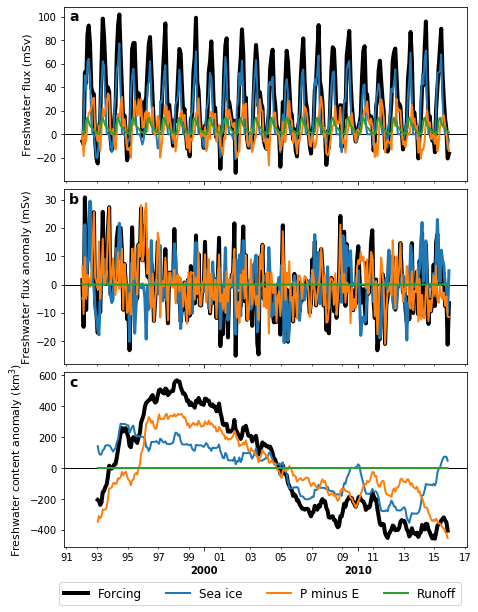

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


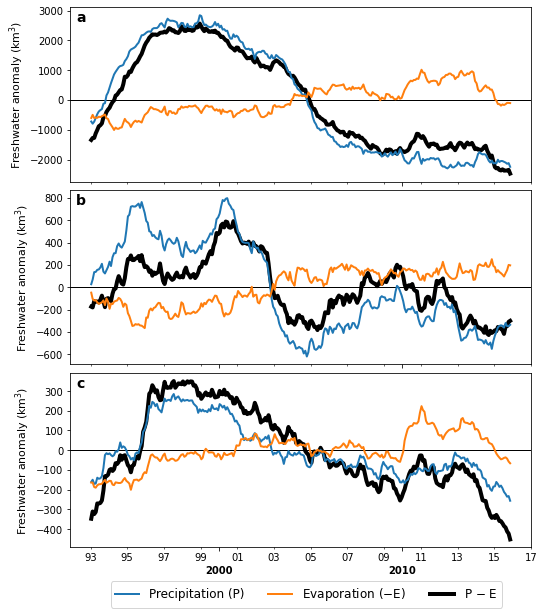

In [51]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwEP')*1e-3, lw=4, color='black', 
        label='P minus E')
axs[0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwP')*1e-3, lw=2, label='P')
axs[0].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='spna',term='forcFwE')*1e-3, lw=2, label='E')
axs[0].set_ylabel('Freshwater anomaly (km$^3$)',fontsize=11)
axs[0].text(0.013,0.92, 'a', fontsize=14, fontweight='bold', transform=axs[0].transAxes)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwEP')*1e-3, lw=4, color='black', 
        label='P minus E')
axs[1].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwP')*1e-3, lw=2, label='P')
axs[1].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='nsea',term='forcFwE')*1e-3, lw=2, label='E')
axs[1].set_ylabel('Freshwater anomaly (km$^3$)',fontsize=11)
axs[1].text(0.013,0.92, 'b', fontsize=14, fontweight='bold', transform=axs[1].transAxes)

axs[2].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwEP')*1e-3, lw=4, color='black', 
        label='P $-$ E')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwP')*1e-3, lw=2,
            label='Precipitation (P)')
axs[2].plot(budgfw_int_anom.time, budgfw_int_anom.sel(region='lsea',term='forcFwE')*1e-3, lw=2,
            label=r'Evaporation ($-$E)')
axs[2].set_ylabel('Freshwater anomaly (km$^3$)',fontsize=11)
axs[2].text(0.013,0.92, 'c', fontsize=14, fontweight='bold', transform=axs[2].transAxes)
axs[2].set_yticks(np.arange(-400,400,100))

format_xaxis(axs[2])

fig.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

handles, labels = axs[2].get_legend_handles_labels()
order = [1,2,0]
axs[2].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              frameon=True, fancybox=True, bbox_to_anchor=(0.95, -0.16), ncol=3, fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()